### **Quantium Data Analytics Virtual Experience Program**

##### **Retail Strategy and Analytics - Task 1**

To get started, download the resource csv data files below and begin performing high level data checks such as:

* Creating and interpreting high level summaries of the data
* Finding outliers and removing these
* Checking data formats and correcting

The above was done in Microsoft Exce were I derive extra features such as pack size and brand name from the data and define metrics of interest using Power Query to enable you to draw insights on who spends on chips and what drives spends for each customer segment. My end goal is to form a strategy based on the findings to provide a clear recommendation to Julia the Category Manager so make sure your insights can have a commercial application.

**LIFESTAGE**: Customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school.


**PREMIUM_CUSTOMER**: Customer segmentation used to differentiate shoppers by the price point of products they buy and the types of products they buy. It is used to identify whether customers may spend more for quality or brand or whether they will purchase the cheapest options.


In [1]:
# required library
# Data analysis and wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

# Dates
import datetime
from matplotlib.dates import DateFormatter

# Text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as FreqDist
import re

# Statistical analysis
from scipy.stats import ttest_ind

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


### Import Data

QVI tranaction data, it's already cleaned in Excel

In [2]:
chip_sales = pd.read_csv('QVI_transaction_data_clean.csv')

In [3]:
chip_sales.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND,PACK_SIZE,UNIT_PRICE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,17/10/2018,1,1000,1,5,Natural Chip Company SeaSalt,Natural Chip Co,175,3.00,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,14/05/2019,1,1307,348,66,CCs Nacho Cheese,CC's,175,2.10,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,20/05/2019,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,Smith's,170,1.45,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,17/08/2018,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion,Smith's,175,3.00,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,18/08/2018,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili,Kettle,150,4.60,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [4]:
# Convert DATE to datetime
chip_sales['DATE'] = pd.to_datetime(chip_sales['DATE'], dayfirst=True)

# Check the date range
print(f"Date range: {chip_sales['DATE'].min()} to {chip_sales['DATE'].max()}")
print(f"Number of unique dates: {chip_sales['DATE'].nunique()}")

Date range: 2018-07-01 00:00:00 to 2019-06-30 00:00:00
Number of unique dates: 364


In [5]:
# Group by date and count transactions
daily_transactions = chip_sales.groupby('DATE').size().reset_index(name='Transaction_byday')

print(f"Number of days with transactions: {len(daily_transactions)}")
daily_transactions.head(10)

Number of days with transactions: 364


,DATE,Transaction_byday
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
5,2018-07-06,711
6,2018-07-07,695
7,2018-07-08,653
8,2018-07-09,692
9,2018-07-10,650


In [6]:
# Create a complete date range
start_date = pd.to_datetime('2018-07-01')
end_date = pd.to_datetime('2019-06-30')

# Generate all dates in the range
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
full_date_df = pd.DataFrame({'DATE': all_dates})

print(f"Total days in period: {len(full_date_df)}")

Total days in period: 365


In [7]:
# Merge the full date range with actual transactions
merged_dates = full_date_df.merge(daily_transactions, on='DATE', how='left')

# Fill NaN with 0 (days with no transactions)
merged_dates['Transaction_byday'] = merged_dates['Transaction_byday'].fillna(0)

# Find the missing date(s)
missing_dates = merged_dates[merged_dates['Transaction_byday'] == 0]

print("\nMissing Date(s):")
print(missing_dates)


Missing Date(s):
          DATE  Transaction_byday
177 2018-12-25                0.0


In [8]:
merged_dates[merged_dates['Transaction_byday'] == 0]

,DATE,Transaction_byday
177,2018-12-25,0.0


In [9]:
chip_sales.groupby(['DATE']).size()

DATE
2018-07-01    663
2018-07-02    650
2018-07-03    674
2018-07-04    669
2018-07-05    660
             ... 
2019-06-26    657
2019-06-27    669
2019-06-28    673
2019-06-29    703
2019-06-30    704
Length: 364, dtype: int64

We have 364 days of sales data. Let's check all 365 days from July 1, 2018 to June 30, 2019 to see which day has no sales.

In [10]:
# Create a new dataframe which contains the total sale for each date

a = pd.pivot_table(chip_sales, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
a.rename(columns={'TOT_SALES':'Total Sales'},inplace=True)

# create new dataframe which total sales 0
b = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
b['Total Sales'] = 0

Transaction_byday = a + b
Transaction_byday.fillna(0, inplace = True)
Transaction_byday.index.name='Date'

In [11]:
Transaction_byday.head()

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


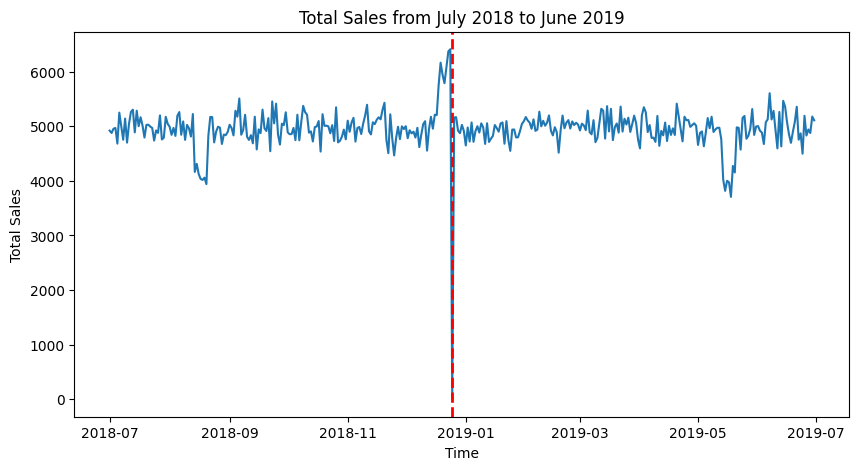

In [12]:
# Plot Total sales for each date
timeline = Transaction_byday.index
graph = Transaction_byday['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.axvline(pd.to_datetime('2018-12-25'), color='red', linestyle='--', linewidth=2, label='Christmas Day')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()

In [13]:
Transaction_byday[Transaction_byday['Total Sales'] == 0]

,Total Sales
Date,
2018-12-25,0.0


In [14]:
# Let's look at the December month only

Transaction_december = Transaction_byday[(Transaction_byday.index<"2019-01-01") & (Transaction_byday.index>"2018-11-30")]
Transaction_december.reset_index(inplace=True)
Transaction_december

,Date,Total Sales
0,2018-12-01,5000.9
1,2018-12-02,4781.1
2,2018-12-03,4927.0
3,2018-12-04,4869.4
4,2018-12-05,4900.5
5,2018-12-06,4792.9
6,2018-12-07,4971.7
7,2018-12-08,4618.4
8,2018-12-09,4844.8
9,2018-12-10,5037.7


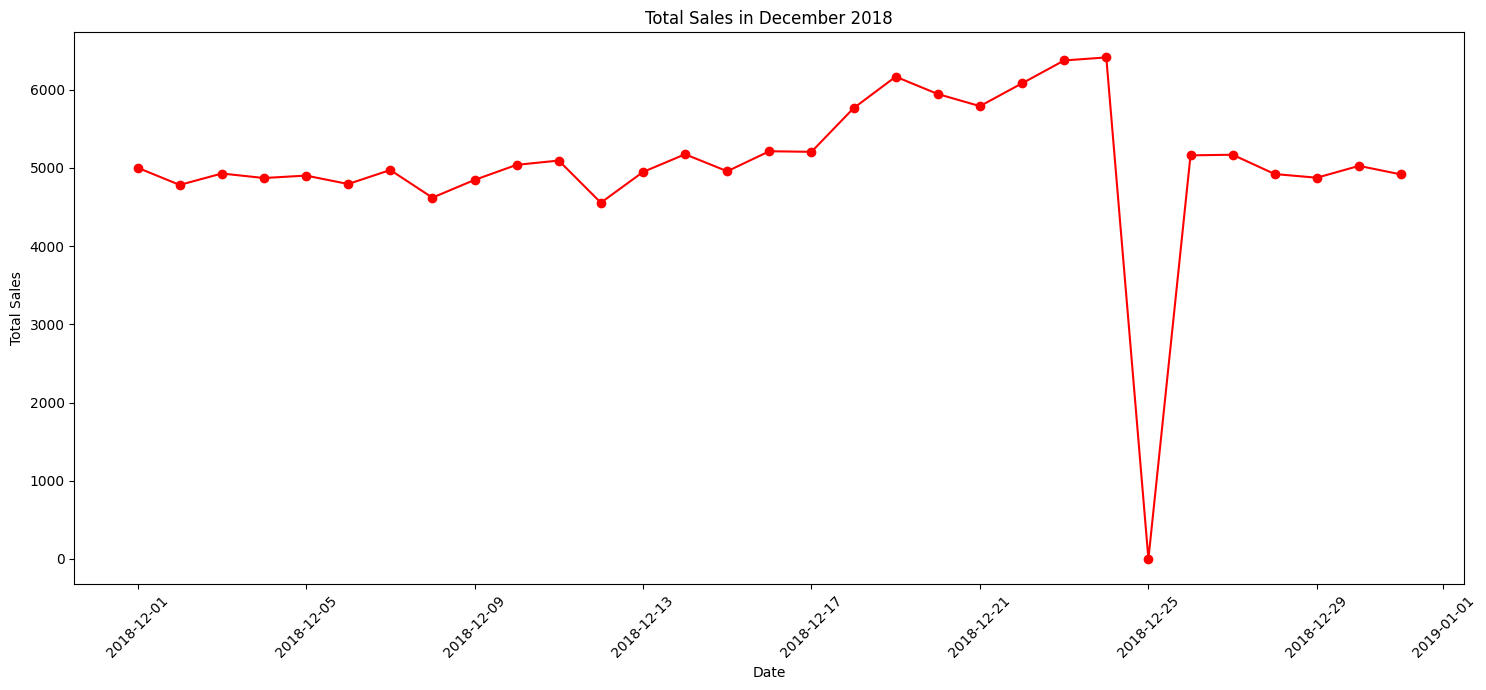

In [15]:
plt.figure(figsize = (15,7))
plt.plot(Transaction_december['Date'], Transaction_december['Total Sales'], color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales in December 2018')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='Date', ylabel='Total Sales'>

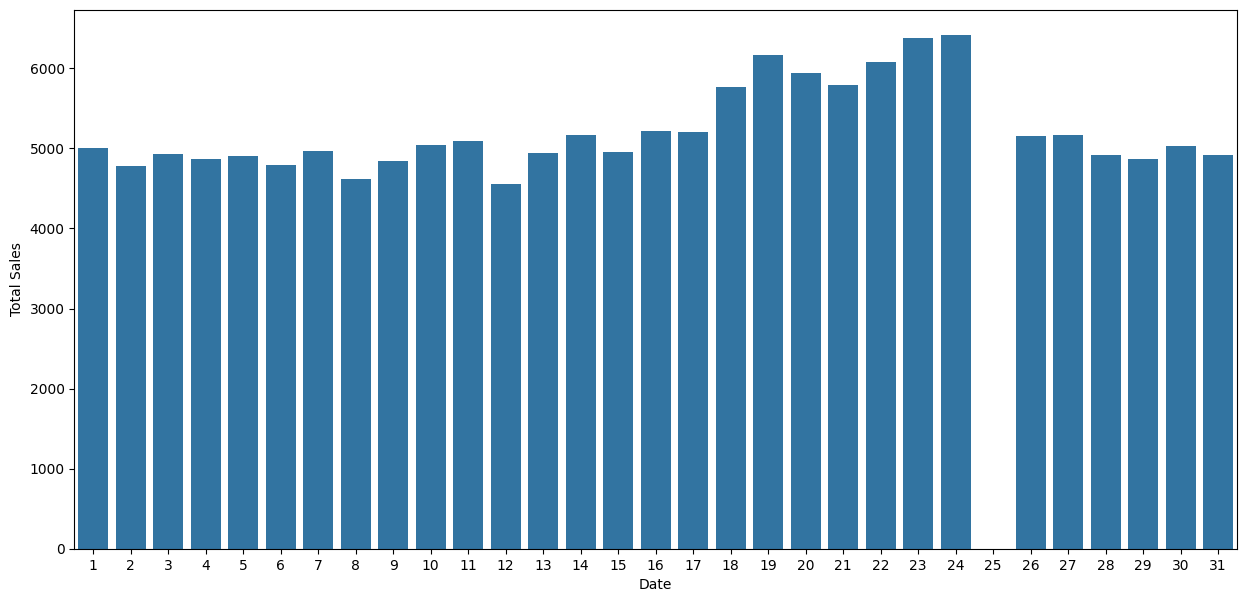

In [16]:
Transaction_december.reset_index(drop = True, inplace = True)
Transaction_december['Date']= Transaction_december.index + 1

plt.figure(figsize = (15,7))
sns.barplot(x= 'Date', y='Total Sales', data = Transaction_december)

We can see sales go up in December, but there are zero sales on December 25 (Christmas Day). This makes sense because shops are closed on Christmas.

In [17]:
# Now let's move to PACK_SIZE
chip_sales['PACK_SIZE'].isnull().sum()

np.int64(0)

Text(0.5, 1.0, 'Transaction by pack size')

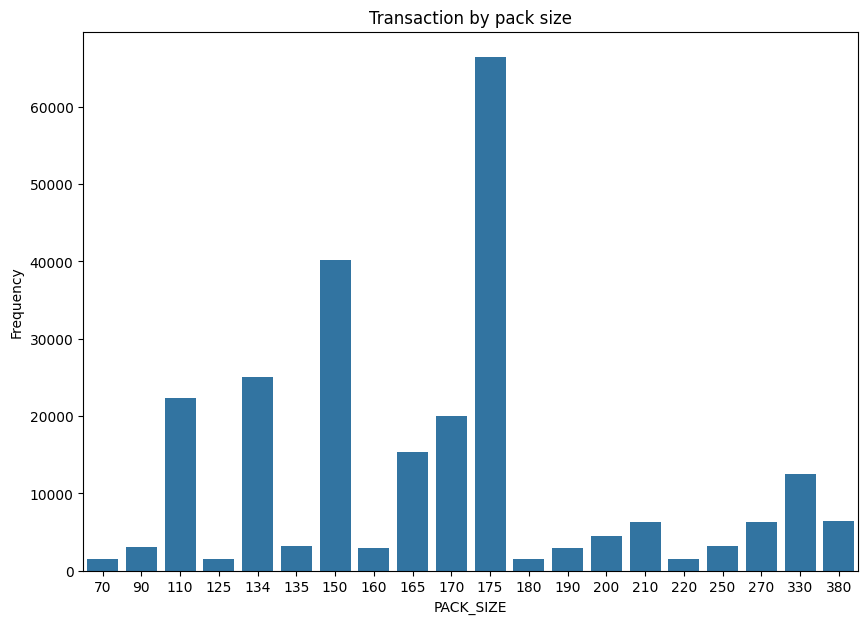

In [18]:
# Let's plot a histogram of PACK_SIZE since we knoe it is a categorical variable and not continous even though it is numeric
d=chip_sales.groupby(['PACK_SIZE']).size().reset_index()
d.rename(columns={0:'Frequency'},inplace=True)

plt.figure(figsize =(10,7))
sns.barplot(x='PACK_SIZE', y = 'Frequency', data=d)
plt.title('Transaction by pack size')

#sns.countplot(x=TransactionData['PACK_SIZE],palette='deep').set(ylabel='Frequency')

The 175g pack size is the most popular size that customers buy.

Text(0.5, 1.0, 'Transactions of Different Brands')

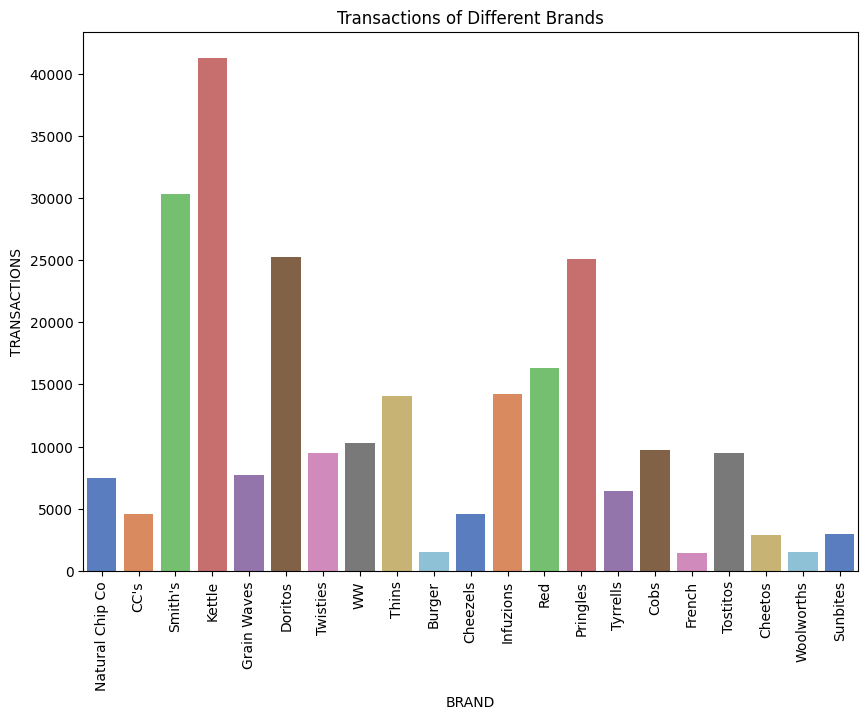

In [19]:
#Plot data by brands
plt.figure(figsize=(10,7))
sns.countplot(x=chip_sales['BRAND'],palette='muted').set(ylabel='TRANSACTIONS')
plt.xticks(rotation=90)
plt.title("Transactions of Different Brands")

Kettle is the most popular brand that customers buy.

In [20]:
# what category in lifestages column
chip_sales['LIFESTAGE'].unique()

<StringArray>
[ 'YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES',           'NEW FAMILIES',
         'OLDER FAMILIES',  'OLDER SINGLES/COUPLES',               'RETIREES',
         'YOUNG FAMILIES']
Length: 7, dtype: str

In [21]:
chip_sales['LIFESTAGE'].value_counts().sort_values(ascending=False)

LIFESTAGE
OLDER SINGLES/COUPLES     50793
RETIREES                  46431
OLDER FAMILIES            45158
YOUNG FAMILIES            40494
YOUNG SINGLES/COUPLES     33969
MIDAGE SINGLES/COUPLES    23398
NEW FAMILIES               6497
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='LIFESTAGE'>

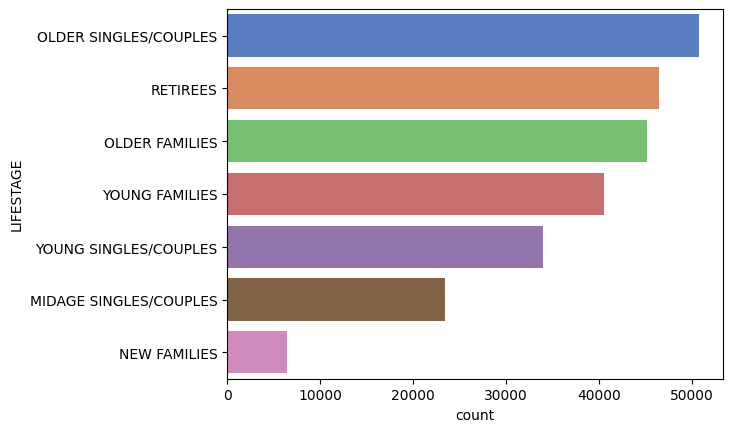

In [22]:
sns.countplot(y=chip_sales['LIFESTAGE'], order = chip_sales['LIFESTAGE'].value_counts().index, palette='muted')

In [23]:
# what categories in premium customer column
chip_sales['PREMIUM_CUSTOMER'].unique()

<StringArray>
['Premium', 'Budget', 'Mainstream']
Length: 3, dtype: str

In [24]:
chip_sales['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending=False)

PREMIUM_CUSTOMER
Mainstream    95043
Budget        86762
Premium       64935
Name: count, dtype: int64

<Axes: xlabel='Premium Customer', ylabel='Number of Customer'>

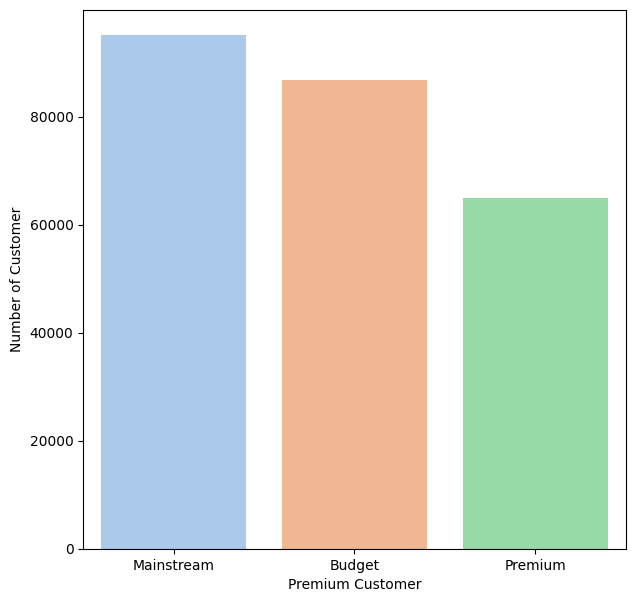

In [25]:
plt.figure(figsize=(7,7))
plt.xlabel('Premium Customer')
plt.ylabel('Number of Customer')
sns.countplot(x=chip_sales['PREMIUM_CUSTOMER'],order=chip_sales['PREMIUM_CUSTOMER'].value_counts().index,palette='pastel')

In [26]:
# check if there is null value

chip_sales.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
BRAND               0
PACK_SIZE           0
UNIT_PRICE          0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

We checked for missing data in each column, and there are no missing values.

#### **Data analysis on Customer Segments**


* Who spends the most on chips (total sales), describing customers by lifestage and how premium their general purchasing behaviour is
* How many customers are in each segment
* How many chips are bought per customer by segment
* what's the average chip price by customer segment

In [27]:
#### Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales = pd.DataFrame(chip_sales.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES' : 'Total Sales'},inplace=True)
sales.sort_values(by = 'Total Sales', ascending = False,inplace=True)
sales

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            156863.75
Mainstream       YOUNG SINGLES/COUPLES     147582.20
                 RETIREES                  145168.95
Budget           YOUNG FAMILIES            129717.95
                 OLDER SINGLES/COUPLES     127833.60
Mainstream       OLDER SINGLES/COUPLES     124648.50
Premium          OLDER SINGLES/COUPLES     123537.55
Budget           RETIREES                  105916.30
Mainstream       OLDER FAMILIES             96413.55
Premium          RETIREES                   91296.65
Mainstream       YOUNG FAMILIES             86338.25
                 MIDAGE SINGLES/COUPLES     84734.25
Premium          YOUNG FAMILIES             78571.70
                 OLDER FAMILIES             75242.60
Budget           YOUNG SINGLES/COUPLES      57122.10
Premium          MIDAGE SINGLES/COUPLES     54443.85
                 YOUNG SINGLES/COUPLES      39052.30
Budget           MIDAGE SINGLES/COUPLES     33345.70
                 NEW FAMILIES               20607.45
Mainstream       NEW FAMILIES               15979.70
Premium          NEW FAMILIES               10760.80

In [28]:
salesv=pd.DataFrame(chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum())

# pivot table salesv
table = pd.pivot_table(salesv, values='TOT_SALES', index=['LIFESTAGE'],
                       columns=['PREMIUM_CUSTOMER'], aggfunc="sum", fill_value=0)
table = table.reset_index()
table = pd.DataFrame(table)
table

PREMIUM_CUSTOMER,LIFESTAGE,Budget,Mainstream,Premium
0,MIDAGE SINGLES/COUPLES,33345.70,84734.25,54443.85
1,NEW FAMILIES,20607.45,15979.70,10760.80
2,OLDER FAMILIES,156863.75,96413.55,75242.60
3,OLDER SINGLES/COUPLES,127833.60,124648.50,123537.55
4,RETIREES,105916.30,145168.95,91296.65
5,YOUNG FAMILIES,129717.95,86338.25,78571.70
6,YOUNG SINGLES/COUPLES,57122.10,147582.20,39052.30


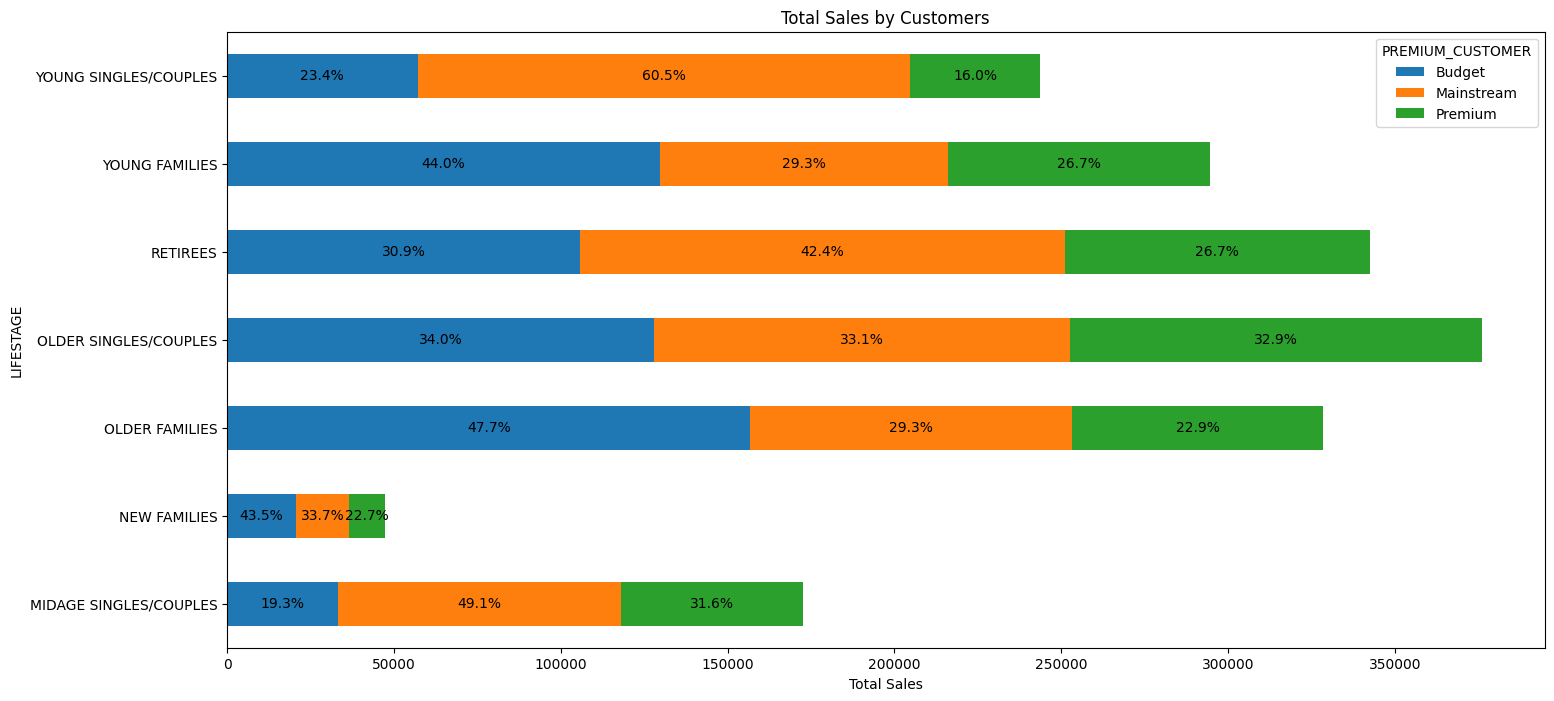

In [29]:
# plot a Stacked Bar Chart using matplotlib
table.plot(
  x = 'LIFESTAGE',
  kind = 'barh',
  stacked = True,
  title = 'Total Sales by Customers',
  mark_right = True,figsize=(17,8)
  )
plt.xlabel('Total Sales')
plt.style.use('seaborn-v0_8-pastel')
df_total = table['Budget'] + table['Mainstream'] + table["Premium"]
df_rel = table[table.columns[1:]].div(df_total, 0) * 100

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(table.iloc[:, 1:].cumsum(1)[n],
                                         table[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%',
                 va = 'center', ha = 'center')

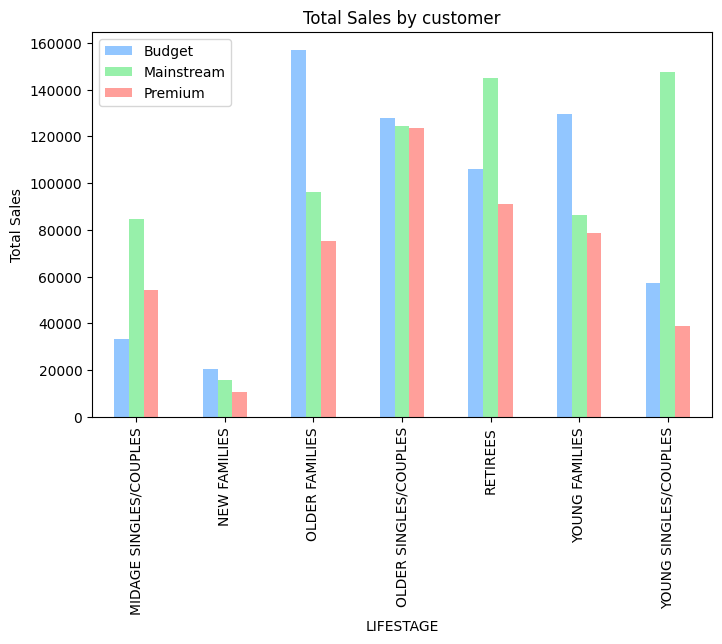

In [32]:
salesv=pd.DataFrame(chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum())
#salesv=pd.DataFrame(data.groupby(['LIFESTAGE']).TOT_SALES.sum().sort_values(ascending=False))
salesv.rename(columns = {'TOT_SALES' : 'Total Sales'},inplace=True)
plt.style.use('seaborn-v0_8-pastel')
salesv.unstack().plot(kind='bar',figsize=(8,5), title = 'Total Sales by customer')
plt.ylabel('Total Sales')
plt.legend(['Budget','Mainstream','Premium'])

The biggest sales come from three groups: Budget shoppers who are older families, Mainstream shoppers who are young singles or couples, and Mainstream shoppers who are retirees. The smallest sales come from Premium shoppers who are new families.

Let's see if the reason for higher sales is that there are simply more customers buying chips in those groups.

In [30]:
import pandas as pd

### Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
customer = pd.DataFrame(chip_sales.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customer.rename(columns = {'LYLTY_CARD_NBR':'Number of Customers'},inplace=True)
customer.sort_values(by='Number of Customers',ascending=False)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                  
Mainstream       YOUNG SINGLES/COUPLES                  7917
                 RETIREES                               6358
                 OLDER SINGLES/COUPLES                  4858
Budget           OLDER SINGLES/COUPLES                  4849
Premium          OLDER SINGLES/COUPLES                  4682
Budget           OLDER FAMILIES                         4611
                 RETIREES                               4385
                 YOUNG FAMILIES                         3953
Premium          RETIREES                               3812
Budget           YOUNG SINGLES/COUPLES                  3647
Mainstream       MIDAGE SINGLES/COUPLES                 3298
                 OLDER FAMILIES                         2788
                 YOUNG FAMILIES                         2685
Premium          YOUNG SINGLES/COUPLES                  2480
                 YOUNG FAMILIES                         2398
                 MIDAGE SINGLES/COUPLES                 2369
                 OLDER FAMILIES                         2231
Budget           MIDAGE SINGLES/COUPLES                 1474
                 NEW FAMILIES                           1087
Mainstream       NEW FAMILIES                            830
Premium          NEW FAMILIES                            575

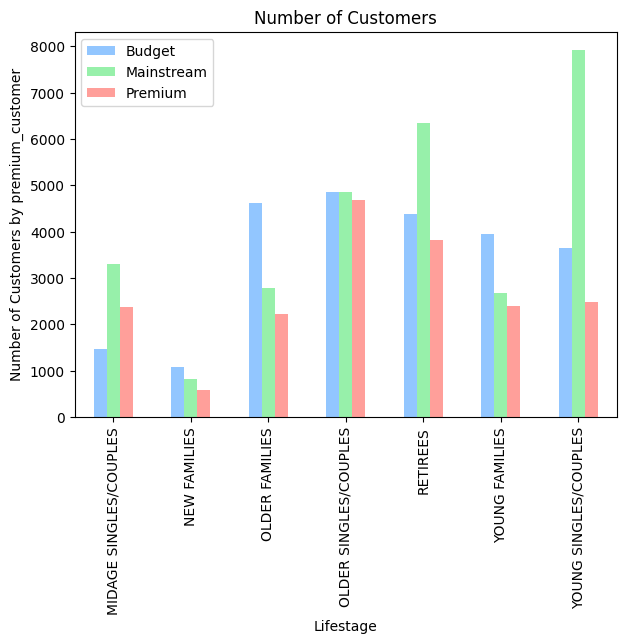

In [31]:
customer_plot = pd.DataFrame(chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
plt.style.use('seaborn-v0_8-pastel')
customer_plot.unstack().plot(kind='bar',figsize=(7,5),title='Number of Customers')
plt.xlabel('Lifestage')
plt.ylabel('Number of Customers by premium_customer')
plt.legend(['Budget','Mainstream','Premium'])

In [32]:
# proportions plot
custv = pd.DataFrame(chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())

# pivot table custv
table = pd.pivot_table(custv, values='LYLTY_CARD_NBR', index=['LIFESTAGE'],
                       columns=['PREMIUM_CUSTOMER'], aggfunc="sum", fill_value=0)
table = table.reset_index()
table = pd.DataFrame(table)
table

PREMIUM_CUSTOMER,LIFESTAGE,Budget,Mainstream,Premium
0,MIDAGE SINGLES/COUPLES,1474,3298,2369
1,NEW FAMILIES,1087,830,575
2,OLDER FAMILIES,4611,2788,2231
3,OLDER SINGLES/COUPLES,4849,4858,4682
4,RETIREES,4385,6358,3812
5,YOUNG FAMILIES,3953,2685,2398
6,YOUNG SINGLES/COUPLES,3647,7917,2480


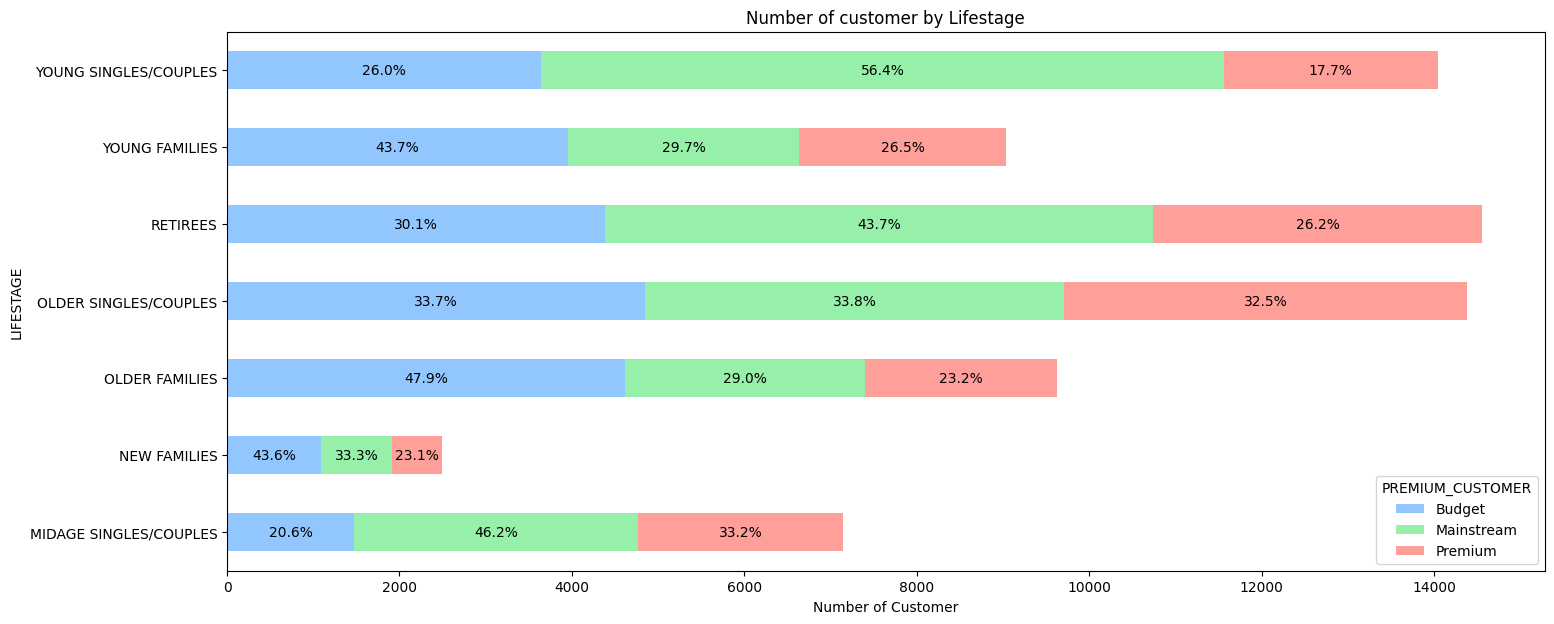

In [33]:
# plot a Stacked Bar Chart using matplotlib
table.plot(
  x = 'LIFESTAGE',
  kind = 'barh',
  stacked = True,
  title = 'Number of customer by Lifestage',
  mark_right = True,figsize=(17, 7)
  )
plt.xlabel('Number of Customer')

df_total = table['Budget'] + table['Mainstream'] + table["Premium"]
df_rel = table[table.columns[1:]].div(df_total, 0) * 100

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(table.iloc[:, 1:].cumsum(1)[n],
                                         table[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%',
                 va = 'center', ha = 'center')

The Mainstream young singles/couples group has the most customers buying chips. However, the high sales for Budget shoppers (older families) is not because there are more of them—it's because each customer in that group buys more.

Higher sales might also come from customers buying more bags of chips per visit. Let's check this.

In [34]:
# Average units per customer by PREMIUM_CUSTOMER and LIFESTAGE

avg_units = chip_sales.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / chip_sales.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units)
avg_units.rename(columns = {0:'Average Unit per Customer'},inplace=True)
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.255380
Budget,OLDER FAMILIES,9.076773
Premium,OLDER FAMILIES,9.071717
Budget,YOUNG FAMILIES,8.722995
Premium,YOUNG FAMILIES,8.716013


Text(0, 0.5, 'Avg units per Transactions')

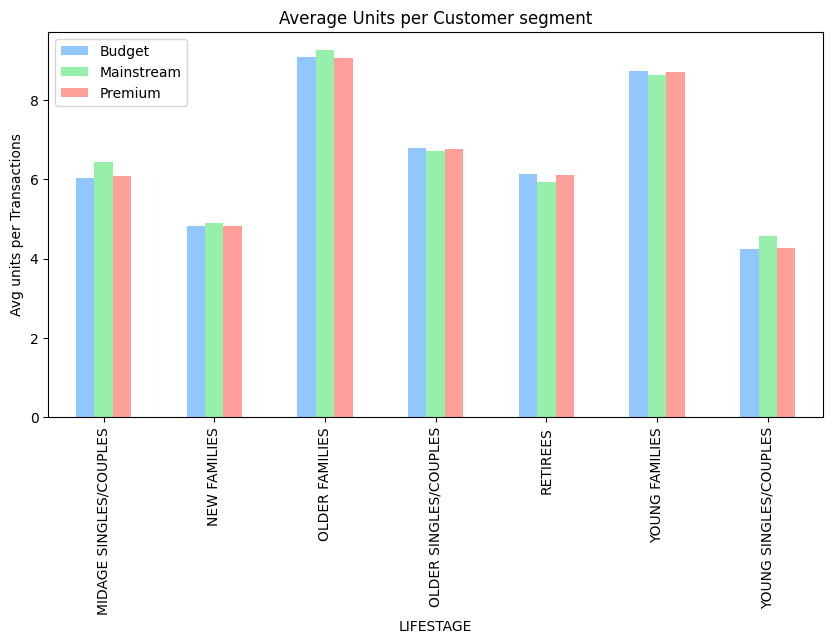

In [35]:
avg_plot = chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).PROD_QTY.sum() / chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique()
avg_plot = pd.DataFrame(avg_plot)
plt.style.use('seaborn-v0_8-pastel')
avg_plot.unstack().plot(kind='bar',figsize=(10,5),title='Average Units per Customer segment')
plt.legend(['Budget','Mainstream','Premium'])
plt.ylabel('Avg units per Transactions')

Older families and young families tend to buy more bags of chips per customer compared to other groups.

Now let's see how much money each customer group spends per bag of chips.

In [37]:
## Average price per unit by  LIFESTAGE and PREMIUM_CUSTOMER

avg_price = chip_sales.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).TOT_SALES.sum()/chip_sales.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price)
avg_price.rename(columns={0:'Average price per unit'},inplace=True)
avg_price.sort_values(by='Average price per unit',ascending=False).head(10)

Average price per unit
PREMIUM_CUSTOMER LIFESTAGE                                     
Mainstream       YOUNG SINGLES/COUPLES                 4.074043
                 MIDAGE SINGLES/COUPLES                3.994449
                 NEW FAMILIES                          3.935887
Budget           RETIREES                              3.932731
                 NEW FAMILIES                          3.931969
Premium          RETIREES                              3.924037
                 OLDER SINGLES/COUPLES                 3.897698
Budget           OLDER SINGLES/COUPLES                 3.887529
Premium          NEW FAMILIES                          3.886168
Mainstream       RETIREES                              3.852986

Text(0, 0.5, 'Avg price per unit')

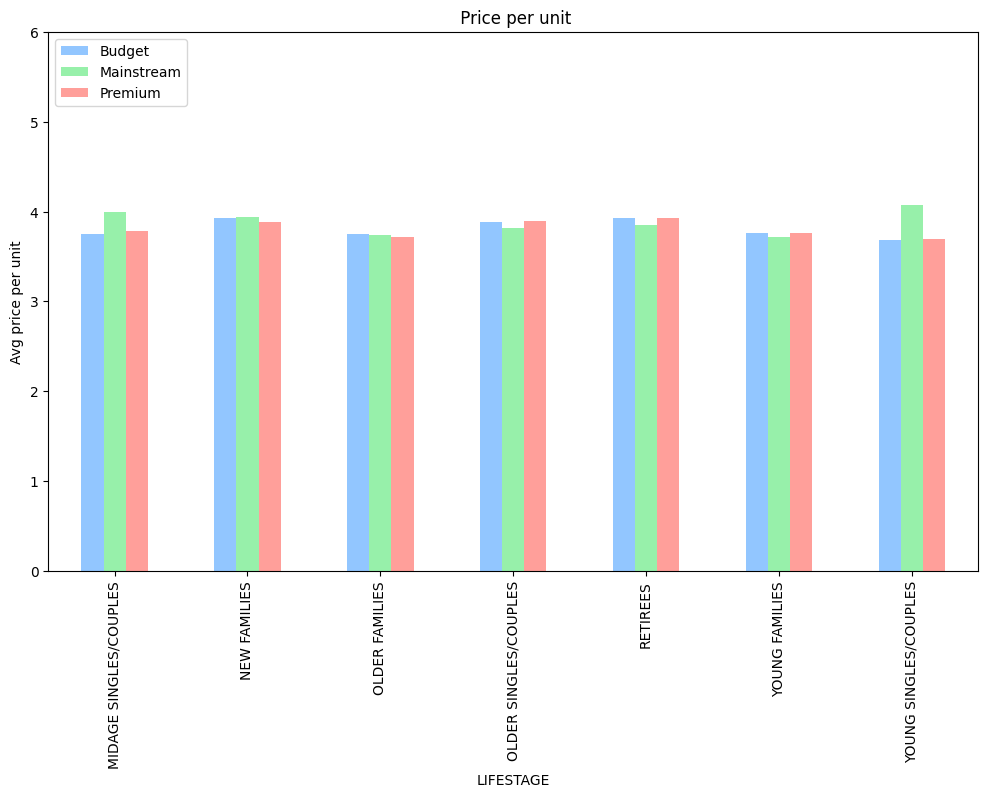

In [38]:
avg_price_plot = chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).TOT_SALES.sum()/chip_sales.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).PROD_QTY.sum()
avg_price_plot = pd.DataFrame(avg_price_plot)
plt.style.use('seaborn-v0_8-pastel')
avg_price_plot.unstack().plot(kind='bar',figsize=(12,7),title=' Price per unit',ylim=(0,6))
plt.legend(['Budget','Mainstream','Premium'],loc= 2)
plt.ylabel('Avg price per unit')

Mainstream young and middle-aged singles or couples are willing to pay more per bag of chips than Budget or Premium shoppers. This might be because Premium shoppers prefer healthier snacks, and when they do buy chips, it's usually for entertaining guests rather than eating themselves. This is also shown by the fact that there are fewer Premium shoppers buying chips in these age groups compared to Mainstream shoppers.

The difference in price per bag doesn't look very big. Let's check if this difference is real and meaningful.

In [39]:
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference

PricePerUnit = chip_sales
PricePerUnit['PRICE'] = PricePerUnit['TOT_SALES']/PricePerUnit['PROD_QTY']
PricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND,PACK_SIZE,UNIT_PRICE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Company SeaSalt,Natural Chip Co,175,3.00,2,6.0,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,CC's,175,2.10,3,6.3,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,Smith's,170,1.45,2,2.9,MIDAGE SINGLES/COUPLES,Budget,1.45
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion,Smith's,175,3.00,5,15.0,MIDAGE SINGLES/COUPLES,Budget,3.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili,Kettle,150,4.60,3,13.8,MIDAGE SINGLES/COUPLES,Budget,4.60


In [40]:
# Let's group our data into mainstream and non-mainstream

mainstream= PricePerUnit.loc[(PricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ((PricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (PricePerUnit['LIFESTAGE'] =='MIDAGE SINGLES/COUPLES')), 'PRICE']
nonmainstream= PricePerUnit.loc[(PricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ((PricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (PricePerUnit['LIFESTAGE'] =='MIDAGE SINGLES/COUPLES')), 'PRICE']

Text(0.5, 0, 'Price per Unit')

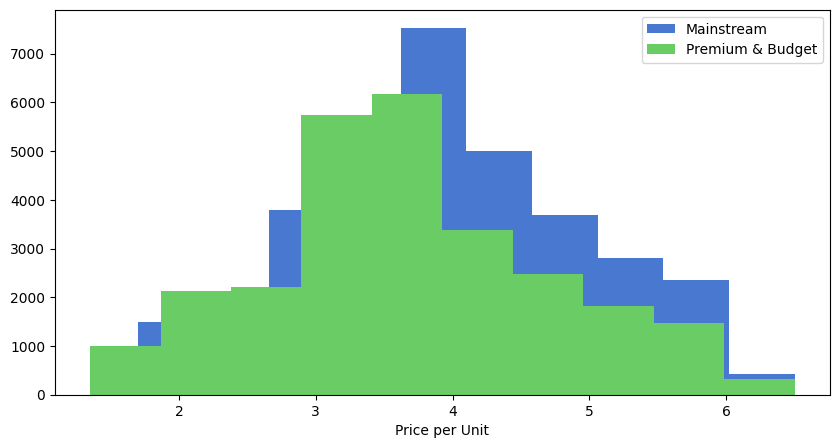

In [41]:
# compare histoframs of mainstream and non-mainstream customers
plt.style.use('seaborn-v0_8-muted')
plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonmainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [42]:
# mainstream avg price per unit
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("Non-Mainstream average price pre unit: ${:.2f}".format(np.mean(nonmainstream)))
if np.mean(mainstream) > np.mean(nonmainstream):
   print("Mainstream customer have higher average price per unit")
else:
   print("Non-Mainstream customer have higher average price per unit")

Mainstream average price per unit: $4.04
Non-Mainstream average price pre unit: $3.71
Mainstream customer have higher average price per unit


In [43]:
# t-test

ttest_ind(mainstream, nonmainstream,equal_var=True)

TtestResult(statistic=np.float64(37.83196107667815), pvalue=np.float64(2.235645611549444e-309), df=np.float64(57365.0))

The price per bag for Mainstream young and middle-aged singles or couples really is higher than for Budget or Premium shoppers in those age groups.

#### **Deep dive into specific  customer segments for insight**

We found some interesting things about how different customer groups buy chips.

We should focus on the customers who bring in the most sales to keep them happy and sell them more. Let's look closely at Mainstream young singles/couples and see if they prefer certain brands compared to other customer groups.

In [44]:
## Deep dive into Mainstream, young singles/couples

segment1 =chip_sales.loc[(chip_sales['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (chip_sales['PREMIUM_CUSTOMER'] == 'Mainstream'), :]
others = chip_sales.loc[(chip_sales['LIFESTAGE'] != 'YOUNG SINGLES/COUPLES' ) & (chip_sales['PREMIUM_CUSTOMER'] != 'Mainstream'), :]
segment1.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND,PACK_SIZE,UNIT_PRICE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
221345,2018-08-16,1,1020,26,19,Smiths Crinkle Cut Snag&Sauce,Smith's,150,2.6,1,2.6,YOUNG SINGLES/COUPLES,Mainstream,2.6
221346,2018-08-17,1,1163,188,46,Kettle Original,Kettle,175,5.4,1,5.4,YOUNG SINGLES/COUPLES,Mainstream,5.4
221347,2018-08-14,1,1291,333,27,WW Supreme Cheese Corn Chips,WW,200,1.9,1,1.9,YOUNG SINGLES/COUPLES,Mainstream,1.9
221348,2019-05-15,3,3031,1227,14,Smiths Crnkle Chip Orgnl Big Bag,Smith's,380,5.9,1,5.9,YOUNG SINGLES/COUPLES,Mainstream,5.9
221349,2019-05-18,3,3118,1574,62,Pringles Mystery Flavour,Pringles,134,3.7,1,3.7,YOUNG SINGLES/COUPLES,Mainstream,3.7


#### **Affinity to Brand**

In [45]:
## Brand affinity

quantity_target = segment1['PROD_QTY'].sum()
quantity_nontarget = others['PROD_QTY'].sum()

targetBrand = segment1.loc[:, ['BRAND','PROD_QTY']]
nontargetBrand = others.loc[:, ['BRAND','PROD_QTY']]

targetBrand['Target Brand Affinity'] = targetBrand['PROD_QTY'] / quantity_target
nontargetBrand['Non-target Brand Affinity'] = nontargetBrand['PROD_QTY'] / quantity_nontarget

targetBrand = pd.DataFrame(targetBrand.groupby('BRAND')['Target Brand Affinity'].sum())
nontargetBrand = pd.DataFrame(nontargetBrand.groupby('BRAND')['Non-target Brand Affinity'].sum())

In [46]:
# Merge two dataframe

Brand_proportions = pd.merge(targetBrand, nontargetBrand, left_index=True, right_index=True)
Brand_proportions['Affinity to Brand'] = Brand_proportions['Target Brand Affinity'] / Brand_proportions['Non-target Brand Affinity']
Brand_proportions.sort_values(by='Affinity to Brand', ascending = False).reset_index()

,BRAND,Target Brand Affinity,Non-target Brand Affinity,Affinity to Brand
0,Tyrrells,0.031553,0.025715,1.227025
1,Twisties,0.046184,0.037933,1.217506
2,Doritos,0.122761,0.101171,1.213397
3,Kettle,0.197985,0.166560,1.188667
4,Tostitos,0.045411,0.038350,1.184100
5,Pringles,0.119420,0.101110,1.181090
6,Cobs,0.044638,0.038449,1.160959
7,Infuzions,0.064679,0.057410,1.126622
8,Thins,0.060373,0.057159,1.056217
9,Grain Waves,0.032712,0.031069,1.052895


Here's what we can see:

*   Mainstream young singles/couples buy Tyrrells chips at a much higher rate—23% more often than other customer groups
*   Mainstream young singles/couples almost avoid Burger brand—56% less likely to buy it than other groups

#### **Affinity to pack size**

In [47]:
# Target : Mainstream young singles couples
TargetSize = segment1.loc[:, ['PACK_SIZE', 'PROD_QTY']]
TargetSum = TargetSize['PROD_QTY'].sum()
TargetSize['Target Pack Affinity'] = TargetSize['PROD_QTY']/TargetSum
TargetSize = pd.DataFrame(TargetSize.groupby('PACK_SIZE')['Target Pack Affinity'].sum())

# Non-Target
NonTargetSize = others.loc[:, ['PACK_SIZE', 'PROD_QTY']]
NonTargetSum = NonTargetSize['PROD_QTY'].sum()
NonTargetSize['Non-Target Pack Affinity'] = NonTargetSize['PROD_QTY']/NonTargetSum
NonTargetSize = pd.DataFrame(NonTargetSize.groupby('PACK_SIZE')['Non-Target Pack Affinity'].sum())

# Merge two Data frame
pack_proportions = pd.merge(TargetSize, NonTargetSize,left_index = True, right_index = True )
pack_proportions['Affinity to Pack'] = pack_proportions['Target Pack Affinity']/ pack_proportions['Non-Target Pack Affinity']
pack_proportions.sort_values(by='Affinity to Pack', ascending=False)

,Target Pack Affinity,Non-Target Pack Affinity,Affinity to Pack
PACK_SIZE,,,
270,0.031829,0.025070,1.269608
380,0.032160,0.025711,1.250827
330,0.061284,0.050974,1.202243
110,0.106280,0.089575,1.186492
134,0.119420,0.101110,1.181090
210,0.029124,0.024891,1.170020
135,0.014769,0.012931,1.142086
250,0.014355,0.012863,1.115959
170,0.080773,0.080347,1.005300


In [49]:
## which brand offer 270g pack size

(pd.DataFrame(chip_sales.loc[chip_sales['PACK_SIZE']==270,:]))['PROD_NAME'].unique()

<StringArray>
['Twisties Cheese', 'Twistikes Chicken']
Length: 2, dtype: str

Only Twisties sells the 270g bag size, so this result really means Mainstream young singles/couples prefer buying Twisties in that size.

#### **Key Findings**

1. **December Sales Spike**: Chip sales go up a lot in December leading up to Christmas, then drop to zero on December 25 when shops are closed.

2. **Top 3 Sales Groups**:
   - Budget-conscious older families
   - Mainstream young singles or couples  
   - Mainstream retirees

3. **Why Some Groups Spend More**: Mainstream young singles/couples and retirees spend more because there are simply more people in these groups buying chips.

4. **Older Families Buy More Per Person**: Budget-conscious older families don't have the most customers, but they buy more bags per person, which is why they have such high total sales.

5. **Young Mainstream Shoppers Spend More**: Mainstream young singles and couples are willing to pay more per bag—this shows they buy chips on impulse without looking for deals.

6. **Brand Preferences**: Mainstream young singles and couples strongly prefer Twisties and Tyrrells brands, and they like the 270g size (which only Twisties makes).

7. **Overall Trends**: Kettle is the most popular brand across all customer groups, while Burger is the least popular. Most people buy the 175g bag size.
